In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose

2024-11-20 11:20:53.692630: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 11:20:53.719971: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 11:20:53.739682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 11:20:53.739702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 11:20:53.739718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
tf.random.set_seed(3)  # Set random seed for reproducibility

In [3]:
# Function to load all sheets from an Excel file into a dictionary with error handling
def load_data(file_path, sheets):
    data_dict = {}
    for key, sheet in sheets.items():
        try:
            data_dict[key] = pd.read_excel(file_path, sheet_name=sheet)
            print(f"Loaded data for {key} from sheet {sheet}")
        except Exception as e:
            print(f"Failed to load data for {key} from sheet {sheet}: {e}")
    return data_dict

In [4]:
# Define the file path and sheet names with their corresponding keys
file_path = "Energy consumption data.xlsx"
sheets = {
    "building_1_gas": "B1G",
    "building_1_electricity": "B1E",
    "building_2_gas": "B2G",
    "building_2_electricity": "B2E",
    "building_3_gas": "B3G",
    "building_3_electricity": "B3E",
}

In [5]:
# Load the data
dictionary = load_data(file_path, sheets)

Loaded data for building_1_gas from sheet B1G
Loaded data for building_1_electricity from sheet B1E
Loaded data for building_2_gas from sheet B2G
Loaded data for building_2_electricity from sheet B2E
Loaded data for building_3_gas from sheet B3G
Loaded data for building_3_electricity from sheet B3E


In [6]:
# Function to visualize data
def visualize_data(df, title, xlabel, ylabel):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set(rc={"figure.figsize": (15, 6)})
    sns.histplot(df["Daily consumption"], bins=50, kde=True, color="blue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
# Function to create and compile the model
def create_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(16, activation="sigmoid"))
    model.add(Dense(output_shape))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae", "mape"]
    )
    return model

In [8]:
# Function to plot data
def plot_the_data(orig_plot, predict_train_plot, predict_test_plot, title):
    plt.figure(figsize=(15, 6))
    plt.plot(orig_plot, color="blue", label="Actual")
    plt.plot(predict_train_plot, color="red", label="Predicted on training")
    plt.plot(predict_test_plot, color="green", label="Predicted on testing")
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.show()

In [9]:
# Model inputs
train_size = 0.7  # 70% of the data is used for training
lookback = 7  # 7 days of data is used to predict the next day

In [10]:
# Example for building 1 (Electricity)
building_name = "building_1_electricity"
df = dictionary[building_name]
df["Daily consumption"] = df.iloc[:, 1:-3].sum(axis=1)

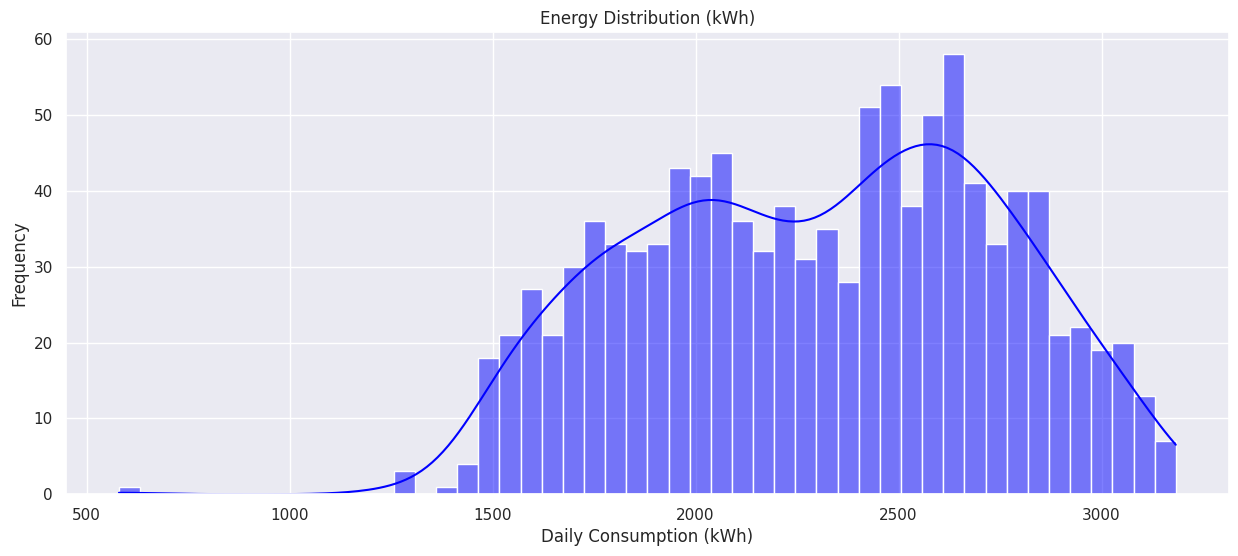

In [11]:
# Visualize data
visualize_data(df, "Energy Distribution (kWh)", "Daily Consumption (kWh)", "Frequency")

In [12]:
# Data preparation functions
def scale_split_datasets(data, train_size, lookback):
    sc_X = StandardScaler()
    daily_consumption_scaled = sc_X.fit_transform(data.values.reshape(-1, 1))
    num_train = int(train_size * len(data))
    training_data = daily_consumption_scaled[:num_train]
    test_data = daily_consumption_scaled[num_train - lookback :]
    return training_data, test_data, sc_X

In [13]:
def create_rnn_dataset(data, lookback):
    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        a = data[i : (i + lookback), 0]
        data_x.append(a)
        data_y.append(data[i + lookback, 0])
    x = np.array(data_x)
    y = np.array(data_y)
    x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    return x, y

In [14]:
def plot_data_preparation(data, predict_on_train, predict_on_test, lookback):
    total_size = len(predict_on_train) + len(predict_on_test)
    orig_data = data.to_numpy().reshape(len(data), 1)
    orig_plot = np.empty((total_size, 1))
    orig_plot[:, :] = np.nan
    orig_plot[:total_size, :] = orig_data[lookback:-2]
    predict_train_plot = np.empty((total_size, 1))
    predict_train_plot[:, :] = np.nan
    predict_train_plot[: len(predict_on_train), :] = predict_on_train
    predict_test_plot = np.empty((total_size, 1))
    predict_test_plot[:, :] = np.nan
    predict_test_plot[len(predict_on_train) : total_size, :] = predict_on_test
    return orig_plot, predict_train_plot, predict_test_plot

In [15]:
# Scale and split data
training_set, test_data, sc_X = scale_split_datasets(
    df["Daily consumption"], train_size, lookback
)
x_train, y_train = create_rnn_dataset(training_set, lookback)
x_test, y_test = create_rnn_dataset(test_data, lookback)

In [16]:
# Create and train the model
ts_model = create_model(input_shape=(1, lookback), output_shape=1)
log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

2024-11-20 11:21:24.430816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 11:21:24.489085: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
ts_model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=1,
    verbose=1,
    callbacks=[tensorboard_callback],
)

Epoch 1/5
759/759 [==============================] - 2s 2ms/step - loss: 0.3218 - mse: 0.3218 - mae: 0.4281 - mape: 232.0928
Epoch 2/5
759/759 [==============================] - 1s 2ms/step - loss: 0.1936 - mse: 0.1936 - mae: 0.3058 - mape: 305.2921
Epoch 3/5
759/759 [==============================] - 1s 2ms/step - loss: 0.1834 - mse: 0.1834 - mae: 0.2995 - mape: 312.5145
Epoch 4/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1765 - mse: 0.1765 - mae: 0.2869 - mape: 275.7008
Epoch 5/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1705 - mse: 0.1705 - mae: 0.2836 - mape: 310.9062


In [18]:
# Evaluate model
ts_model.evaluate(x_test, y_test, verbose=1)
predict_on_train = ts_model.predict(x_train)
predict_on_test = ts_model.predict(x_test)

11/11 [==============================] - 0s 1ms/step


In [19]:
predict_on_train = sc_X.inverse_transform(predict_on_train)
predict_on_test = sc_X.inverse_transform(predict_on_test)

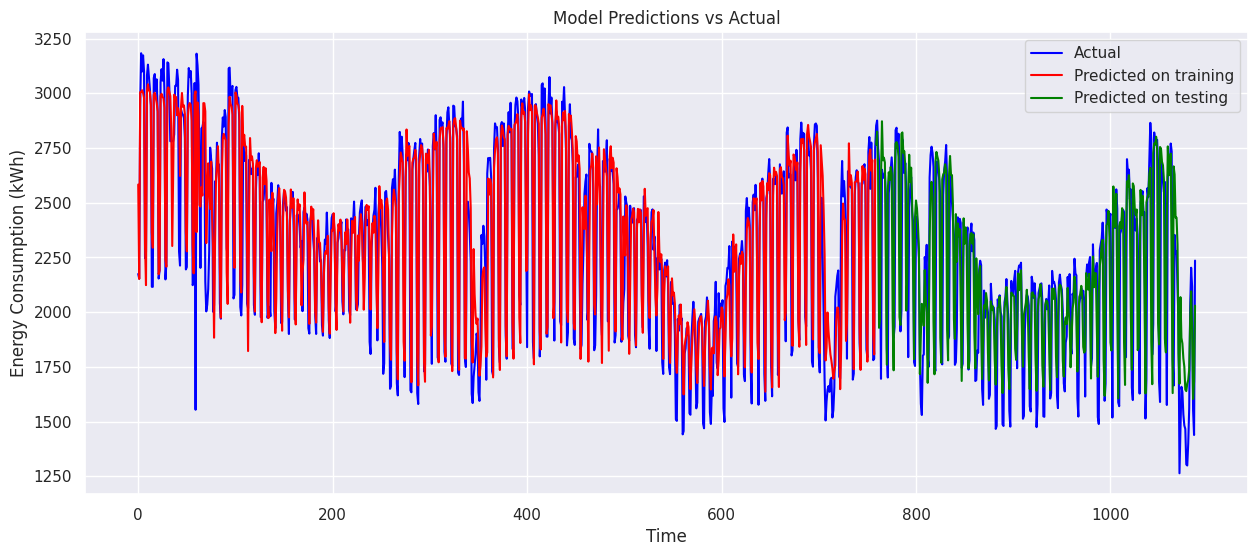

In [20]:
# Plot predictions
plot_original, plot_train, plot_test = plot_data_preparation(
    df["Daily consumption"], predict_on_train, predict_on_test, lookback
)
plot_the_data(plot_original, plot_train, plot_test, "Model Predictions vs Actual")

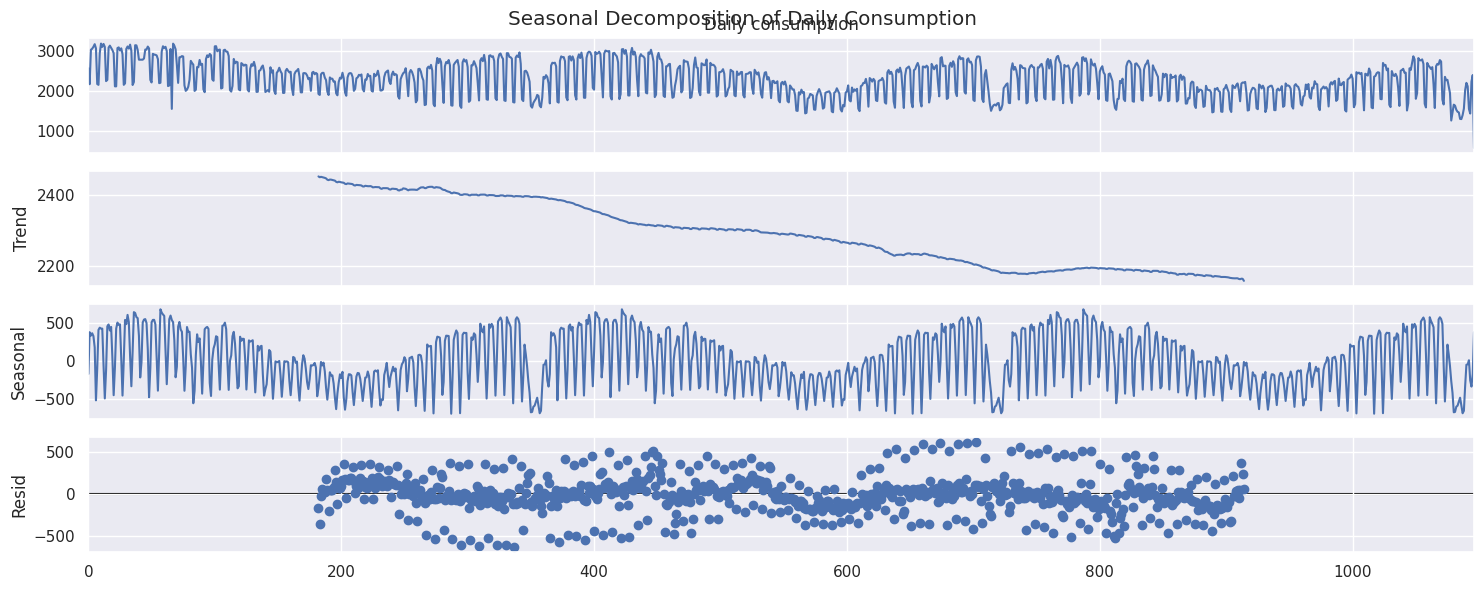

In [21]:
# Seasonal decomposition
result = seasonal_decompose(df["Daily consumption"], model="additive", period=365)
result.plot()
plt.suptitle("Seasonal Decomposition of Daily Consumption")
plt.show()

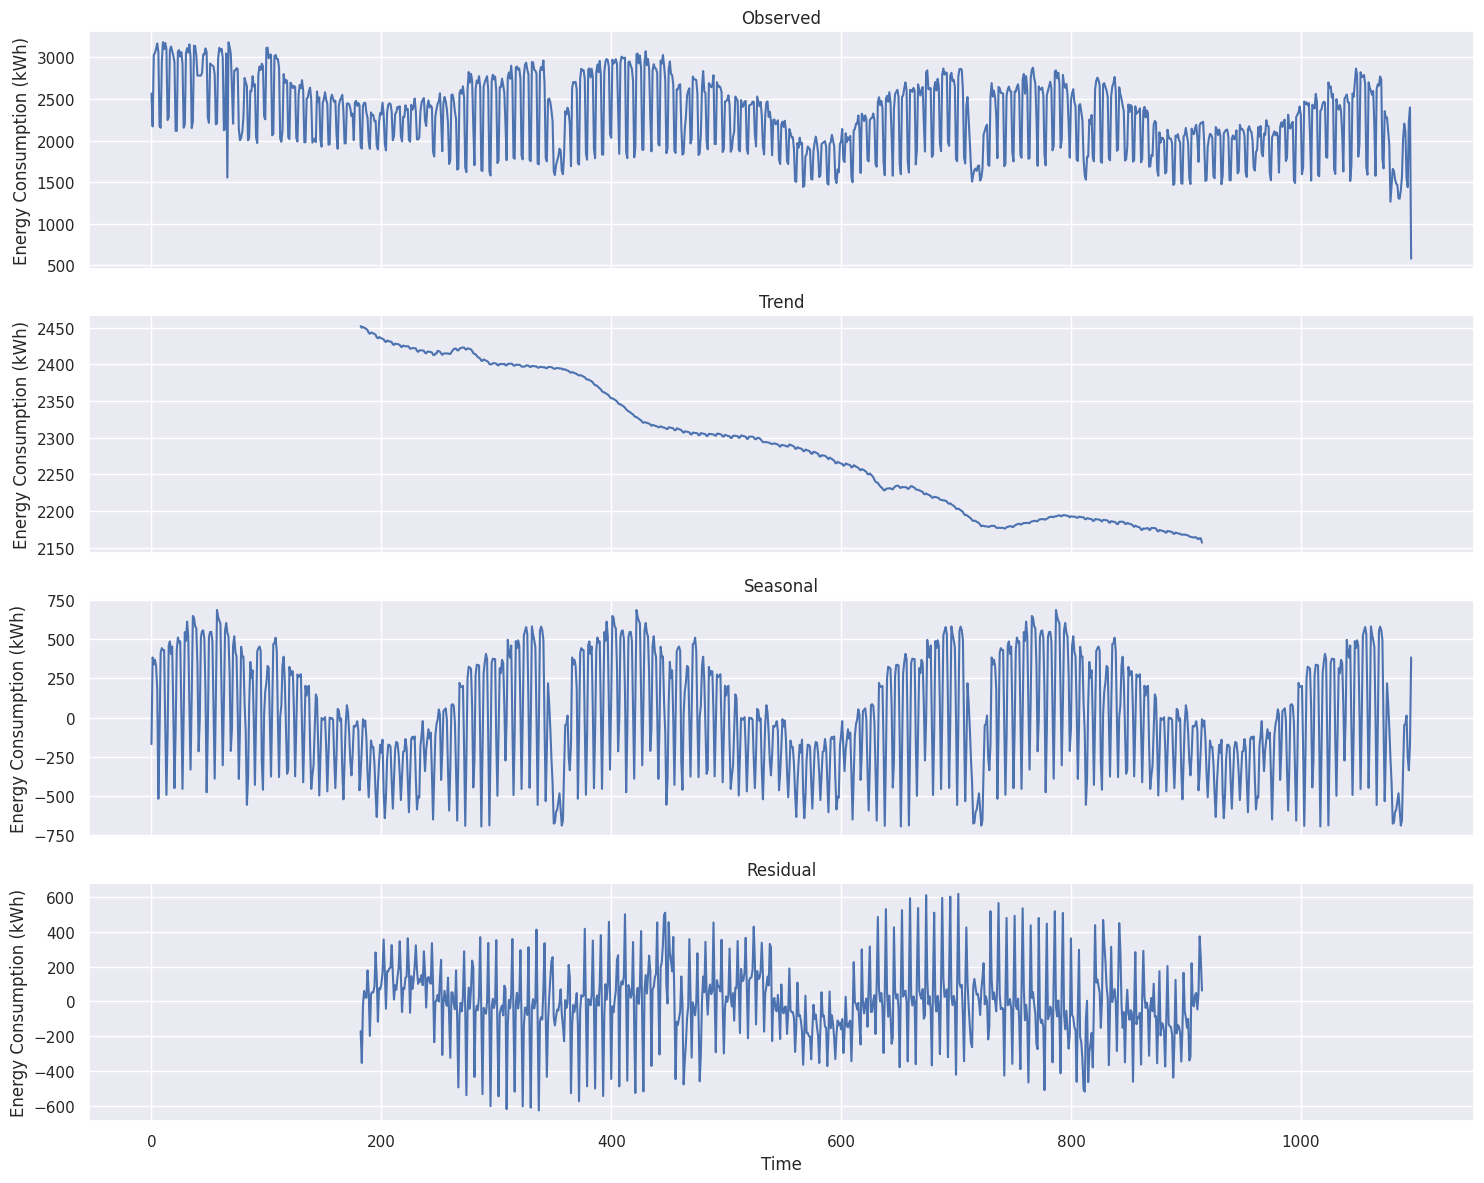

In [22]:
# Enhanced visualization of seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=axes[0], title="Observed")
result.trend.plot(ax=axes[1], title="Trend")
result.seasonal.plot(ax=axes[2], title="Seasonal")
result.resid.plot(ax=axes[3], title="Residual")
for ax in axes:
    ax.set_ylabel("Energy Consumption (kWh)")
axes[3].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [23]:
# Save the residuals to an Excel file
os.makedirs(building_name, exist_ok=True)
pd.DataFrame(result.resid).to_excel(
    f"{building_name}/building.xlsx", sheet_name="Decomposition_Residuals"
)

In [24]:
# Summary statistics
residual_stats = pd.DataFrame(
    {
        "Mean": [result.resid.mean()],
        "Median": [result.resid.median()],
        "Standard Deviation": [result.resid.std()],
        "Max": [result.resid.max()],
        "Min": [result.resid.min()],
    }
)

In [25]:
# Save summary statistics
residual_stats.to_excel(f"{building_name}/residual_statistics.xlsx", index=False)

In [26]:
# Display summary statistics
print("Summary Statistics of Residuals:")
print(residual_stats)

Summary Statistics of Residuals:
       Mean    Median  Standard Deviation         Max         Min
0 -5.159784 -5.555738          217.477239  617.718949 -628.038517


In [27]:
# Evaluation metrics
metrics = ts_model.evaluate(x_test, y_test, verbose=1)
metrics_df = pd.DataFrame([metrics], columns=["Loss", "MSE", "MAE", "MAPE"])

11/11 [==============================] - 0s 1ms/step - loss: 0.1773 - mse: 0.1773 - mae: 0.3123 - mape: 90.3052


In [28]:
# Save evaluation metrics
metrics_df.to_excel(f"{building_name}/evaluation_metrics.xlsx", index=False)

In [29]:
# Display evaluation metrics
print("Evaluation Metrics:")
print(metrics_df)

Evaluation Metrics:
       Loss       MSE       MAE       MAPE
0  0.177316  0.177316  0.312331  90.305153


In [30]:
# Federated Learning Model Preparation
def create_train_test_dataset(df, lookback):
    df["Daily consumption"] = df.iloc[:, 1:-3].sum(axis=1)
    sc_X = StandardScaler()
    daily_consumption = df["Daily consumption"]
    num_train = int(train_size * len(daily_consumption))
    daily_consumption_scaled = sc_X.fit_transform(
        daily_consumption.values.reshape(-1, 1)
    )
    training_set = daily_consumption_scaled[:num_train]
    x_train, y_train = create_rnn_dataset(training_set, lookback)
    test_data = daily_consumption_scaled[num_train - lookback :]
    x_test, y_test = create_rnn_dataset(test_data, lookback)
    return x_train, y_train, x_test, y_test, sc_X

In [31]:
b1e_xtrain, b1e_ytrain, b1e_xtest, b1e_ytest, sc_b1e = create_train_test_dataset(
    dictionary["building_1_electricity"], lookback
)
b2e_xtrain, b2e_ytrain, b2e_xtest, b2e_ytest, sc_b2e = create_train_test_dataset(
    dictionary["building_2_electricity"], lookback
)
b3e_xtrain, b3e_ytrain, b3e_xtest, b3e_ytest, sc_b3e = create_train_test_dataset(
    dictionary["building_3_electricity"], lookback
)

In [32]:
b1e_model = create_model(input_shape=(1, lookback), output_shape=1)
b2e_model = create_model(input_shape=(1, lookback), output_shape=1)
b3e_model = create_model(input_shape=(1, lookback), output_shape=1)

In [33]:
def train_model(model, x_train, y_train, log_dir):
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(
        monitor="loss", min_delta=0.001, patience=5, verbose=1, mode="auto"
    )
    model.fit(
        x_train,
        y_train,
        epochs=60,
        batch_size=1,
        verbose=1,
        callbacks=[tensorboard_callback, early_stopping],
    )

In [34]:
train_model(b3e_model, b3e_xtrain, b3e_ytrain, "logs/fit/B3/")
train_model(b1e_model, b1e_xtrain, b1e_ytrain, "logs/fit/B1/")
train_model(b2e_model, b2e_xtrain, b2e_ytrain, "logs/fit/B2/")

Epoch 1/60
758/758 [==============================] - 2s 2ms/step - loss: 0.3940 - mse: 0.3940 - mae: 0.4758 - mape: 214.0249
Epoch 2/60
758/758 [==============================] - 1s 2ms/step - loss: 0.2317 - mse: 0.2317 - mae: 0.3587 - mape: 186.1830
Epoch 3/60
758/758 [==============================] - 1s 2ms/step - loss: 0.2159 - mse: 0.2159 - mae: 0.3463 - mape: 184.1521
Epoch 4/60
758/758 [==============================] - 1s 2ms/step - loss: 0.1989 - mse: 0.1989 - mae: 0.3291 - mape: 181.0715
Epoch 5/60
758/758 [==============================] - 1s 1ms/step - loss: 0.1898 - mse: 0.1898 - mae: 0.3191 - mape: 143.1604
Epoch 6/60
758/758 [==============================] - 1s 2ms/step - loss: 0.1756 - mse: 0.1756 - mae: 0.3066 - mape: 104.5693
Epoch 7/60
758/758 [==============================] - 1s 1ms/step - loss: 0.1690 - mse: 0.1690 - mae: 0.2957 - mape: 100.5956
Epoch 8/60
758/758 [==============================] - 1s 1ms/step - loss: 0.1607 - mse: 0.1607 - mae: 0.2905 - mape: 9

In [35]:
# Evaluate the models
def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.evaluate(x_train, y_train)
    model.evaluate(x_test, y_test)

In [36]:
evaluate_model(b3e_model, b3e_xtrain, b3e_ytrain, b3e_xtest, b3e_ytest)
evaluate_model(b1e_model, b1e_xtrain, b1e_ytrain, b1e_xtest, b1e_ytest)
evaluate_model(b2e_model, b2e_xtrain, b2e_ytrain, b2e_xtest, b2e_ytest)

11/11 [==============================] - 0s 1ms/step - loss: 0.1520 - mse: 0.1520 - mae: 0.2725 - mape: 109.7075


In [37]:
# Federated model training
def federated_averaging(models, x_train, y_train, rounds=10):
    for _ in range(rounds):
        weights = [model.get_weights() for model in models]
        new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
        for model in models:
            model.set_weights(new_weights)
            model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=1)

In [38]:
models = [b1e_model, b2e_model, b3e_model]
federated_averaging(models, b1e_xtrain, b1e_ytrain)
federated_averaging(models, b2e_xtrain, b2e_ytrain)
federated_averaging(models, b3e_xtrain, b3e_ytrain)

Epoch 1/5
759/759 [==============================] - 1s 1ms/step - loss: 0.2290 - mse: 0.2290 - mae: 0.3528 - mape: 500.6823
Epoch 2/5
759/759 [==============================] - 1s 2ms/step - loss: 0.1656 - mse: 0.1656 - mae: 0.2808 - mape: 455.2185
Epoch 3/5
759/759 [==============================] - 4s 5ms/step - loss: 0.1566 - mse: 0.1566 - mae: 0.2741 - mape: 429.2769
Epoch 4/5
759/759 [==============================] - 1s 2ms/step - loss: 0.1510 - mse: 0.1510 - mae: 0.2597 - mape: 265.9274
Epoch 5/5
759/759 [==============================] - 1s 2ms/step - loss: 0.1461 - mse: 0.1461 - mae: 0.2579 - mape: 424.3644
Epoch 1/5
759/759 [==============================] - 1s 2ms/step - loss: 0.2281 - mse: 0.2281 - mae: 0.3513 - mape: 506.0062
Epoch 2/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1621 - mse: 0.1621 - mae: 0.2769 - mape: 459.5584
Epoch 3/5
759/759 [==============================] - 1s 2ms/step - loss: 0.1532 - mse: 0.1532 - mae: 0.2707 - mape: 434.5494


In [39]:
# Predictions and plotting
def inverse_transform_predictions(predictions, scaler):
    return scaler.inverse_transform(predictions)

In [40]:
b1_train_predictions = inverse_transform_predictions(
    b1e_model.predict(b1e_xtrain), sc_b1e
)
b2_train_predictions = inverse_transform_predictions(
    b2e_model.predict(b2e_xtrain), sc_b2e
)
b3_train_predictions = inverse_transform_predictions(
    b3e_model.predict(b3e_xtrain), sc_b3e
)

24/24 [==============================] - 0s 800us/step


In [41]:
b1_test_predictions = inverse_transform_predictions(
    b1e_model.predict(b1e_xtest), sc_b1e
)
b2_test_predictions = inverse_transform_predictions(
    b2e_model.predict(b2e_xtest), sc_b2e
)
b3_test_predictions = inverse_transform_predictions(
    b3e_model.predict(b3e_xtest), sc_b3e
)

11/11 [==============================] - 0s 944us/step


In [42]:
def prepare_and_plot(data, train_predictions, test_predictions, lookback, title):
    orig_plot, train_plot, test_plot = plot_data_preparation(
        data, train_predictions, test_predictions, lookback
    )
    plot_the_data(orig_plot, train_plot, test_plot, title)

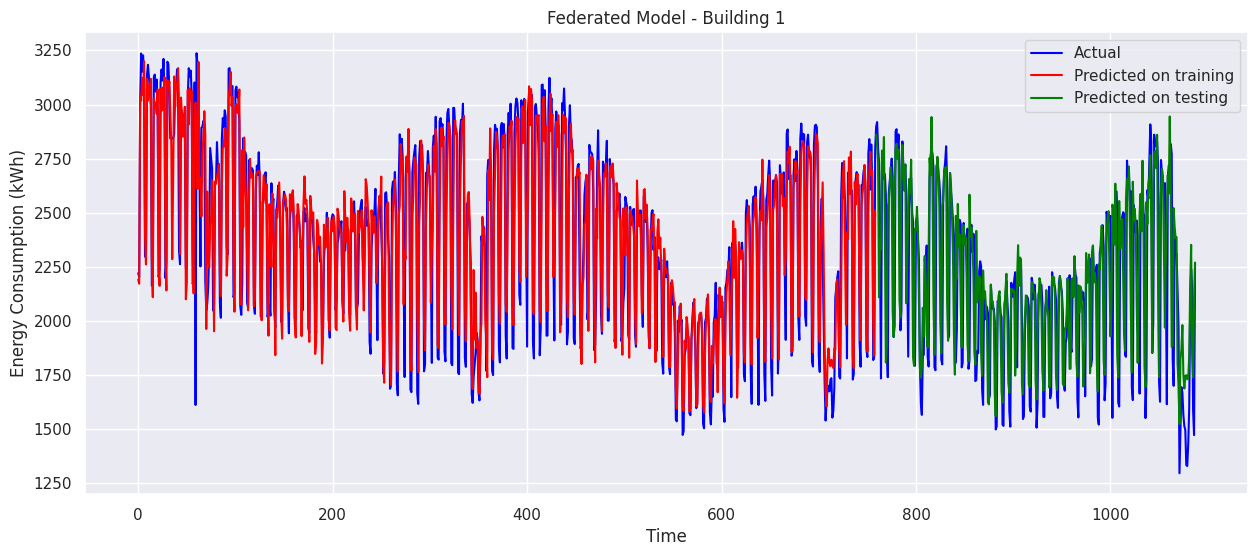

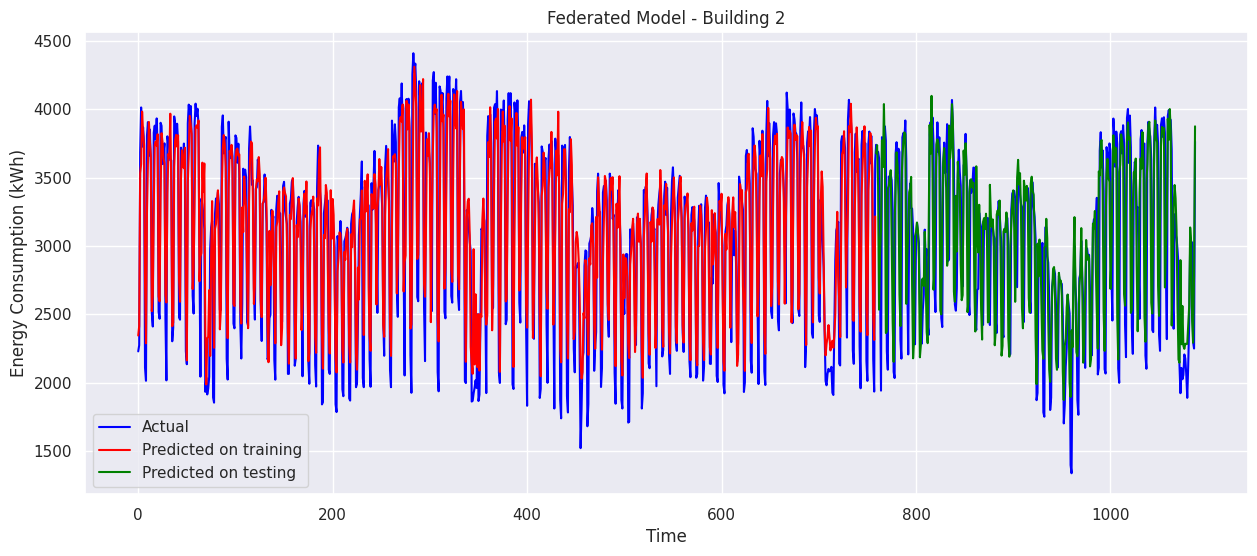

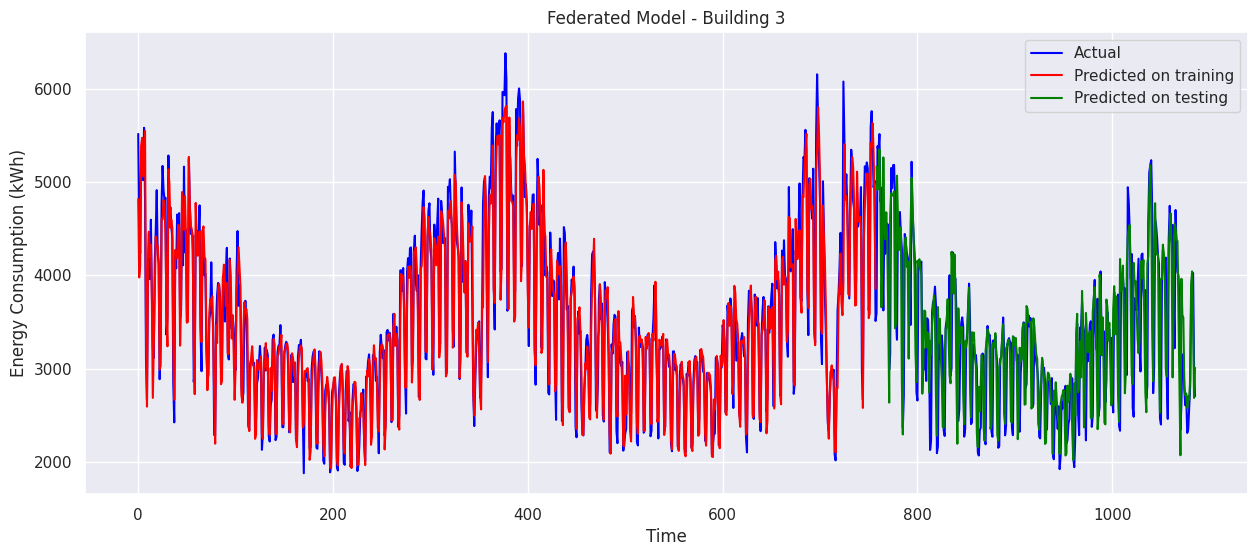

In [43]:
prepare_and_plot(
    dictionary["building_1_electricity"]["Daily consumption"],
    b1_train_predictions,
    b1_test_predictions,
    lookback,
    "Federated Model - Building 1",
)
prepare_and_plot(
    dictionary["building_2_electricity"]["Daily consumption"],
    b2_train_predictions,
    b2_test_predictions,
    lookback,
    "Federated Model - Building 2",
)
prepare_and_plot(
    dictionary["building_3_electricity"]["Daily consumption"],
    b3_train_predictions,
    b3_test_predictions,
    lookback,
    "Federated Model - Building 3",
)

In [44]:
# Save the predictions
output_dir = "federated"
os.makedirs(output_dir, exist_ok=True)

In [45]:
predictions_files = {
    "b1_test_predictions": b1_test_predictions,
    "b2_test_predictions": b2_test_predictions,
    "b3_test_predictions": b3_test_predictions,
    "b1_train_predictions": b1_train_predictions,
    "b2_train_predictions": b2_train_predictions,
    "b3_train_predictions": b3_train_predictions,
    "b1_original": dictionary["building_1_electricity"]["Daily consumption"],
    "b2_original": dictionary["building_2_electricity"]["Daily consumption"],
    "b3_original": dictionary["building_3_electricity"]["Daily consumption"],
}

In [46]:
for filename, data in predictions_files.items():
    pd.DataFrame(data).to_excel(f"{output_dir}/{filename}.xlsx")